# Simulated adstock feature

This notebook builds a simulated dataset for a fictional seasonal product and fits a LightGBM model. A function is used to simultaneously optimise hyperparameters and to estimate adstock parameters (decay and saturation for negative exponential decay).

In [1]:
import datetime as dt
import importlib
import os
import random
import shap

import itertools as it
import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.express as px

from pandas.api.types import CategoricalDtype

from scipy.linalg import eigh

from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.pyll.base import scope

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, \
    RobustScaler, OrdinalEncoder, StandardScaler, MinMaxScaler, \
    PowerTransformer, FunctionTransformer

from mizani.formatters import percent_format
from plotnine import ggplot, aes, geom_line, facet_wrap, theme, \
    labs, geom_vline, geom_text, geom_area, geom_point, geom_histogram, geom_smooth, \
    coord_flip, geom_bar, geom_abline, geom_hline, xlim, scale_x_continuous, \
    scale_color_manual, scale_fill_manual, scale_fill_discrete, \
    scale_y_continuous, ylim, coord_cartesian
from seaborn import pairplot

import warnings
warnings.filterwarnings('ignore')

import shapley
from regression_diagnostics import RegressionDiagnostics

## Globals

In [2]:
MY_PATH = os.path.dirname(os.getcwd())

## Adstock transformer

In [3]:
class AdstockTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, decay=0.5, saturation=1.0, round_digits=3):
        self.decay = decay
        self.saturation = saturation
        self.round_digits = round_digits # this is included as a 'noise gate'
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Convert to numpy array if pandas datafrome
        if type(X) == pd.DataFrame:
            X = X.values
        
        X_t = np.apply_along_axis(
            lambda x: list(
                it.accumulate(x, lambda a, b: 1 - np.exp(-self.saturation * b) + self.decay * a)),
            axis=0, arr=X)
        X_t = np.round(X_t, self.round_digits)
        
        return X_t

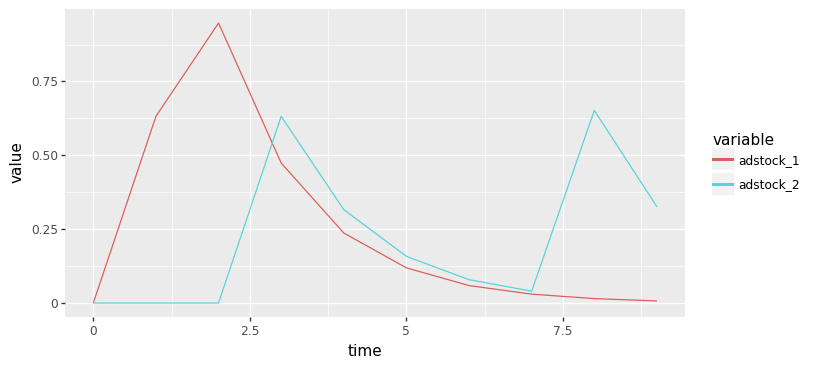

<ggplot: (-9223371928883934944)>

In [4]:
# Check AdstockTransformer
np.random.seed(18)
a = np.reshape(np.random.choice([0, 1], size=20, p=[0.85, 0.15]), (10,2))
ad = AdstockTransformer(decay=0.5, saturation=1.0)

a_t = pd.DataFrame(ad.transform(a),
                   columns=["adstock_1", "adstock_2"])
a_t.reset_index(inplace=True)
a_t.rename(columns={"index": "time"}, inplace=True)

a_t_melt = a_t.melt(id_vars="time")

(ggplot(a_t_melt, aes(x="time", y="value", colour="variable")) +
 geom_line() +
 theme(figure_size=(8,4))
)

## Build dataset

Simulate metrics for a fictional product that is influenced by seasonality,
weather, and promotions

In [5]:
def build_metrics(num_years=4, seed=None):
    """Build simulated metrics for a fictional (seasonal) product
    
    Builds metrics including weather and promotional 'deals'
    
    Parameters
    ----------
    num_years : int
        Number of 'years' to generate data for
        
    seed : int, optional default=None
        Random seed for numpy randomstate
        
    Returns
    -------
    df_base : pandas DataFrame
        Simulated metrics
    """
    if seed:
        np.random.seed(seed)
    
    num_days = 364
    
    # Seasonality
    x_seasonality = list((np.sin(np.arange(-0.5, 1.5, 2 / num_days) * np.pi) + 1) / 2)
    x_seasonality *= num_years

    # Rainy days
    rainy_days = np.random.choice(range(num_days * num_years),
                                  np.int(0.25 * num_days * num_years),
                                  replace = False)
    x_rain = [x in rainy_days for x in range(
        num_days * num_years)] * np.random.exponential(1.5, num_days * num_years)

    # Sun hours and temperature variation from long-term (correlated)
    x_sun_temp = np.random.normal(0, 1, size = (2, num_days * num_years))

    # Covariance matrix
    r = np.array([
        [1, 0.6],
        [0.6, 1]
        ])

    # Get eigenvalues and eigenvectors
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r
    c = np.dot(evecs, np.diag(np.sqrt(evals)))
    x_sun_temp_new = np.dot(c, x_sun_temp)

    x_sun = x_sun_temp_new[0,]
    x_temp = x_sun_temp_new[1,]

    # Deal weeks (arbitrarily restricted to middle of year)
    no_of_deals = 2
    deal_weeks = np.random.choice(range(10, 42),
                                  no_of_deals * num_years, replace = False)
    deal_weeks_df = pd.DataFrame(zip(
        it.chain.from_iterable(
            it.repeat(x,no_of_deals) for x in range(num_years)),
        deal_weeks), columns = ["YEAR", "WEEK"]).sort_values(
        ["YEAR", "WEEK"]).reset_index(drop = True)
    deal_weeks_df["DEAL"] = 1

    # Build data frame
    df_base = pd.DataFrame(zip(
        [x % num_days for x in range(num_days * num_years)],
        x_seasonality), columns = ["DOY", "SEASONAL"]).assign(
        RAIN = x_rain,
        SUN_HOURS = x_sun,
        MAX_TEMP = x_temp,
    )
    df_base["WEEK"] = df_base.DOY.apply(lambda x: int(x / 7) % 52)
    df_base["YEAR"] = list(it.chain.from_iterable(
        it.repeat(x, num_days) for x in range(num_years)))

    df_base = df_base.merge(deal_weeks_df, how = "left",
                            on = ["YEAR", "WEEK"]).fillna(0)
    
    return df_base[["YEAR", "WEEK", "DOY", "SEASONAL", "RAIN",
                    "SUN_HOURS", "MAX_TEMP", "DEAL"]]

In [6]:
# Generate metrics for a 4 year period
metrics = build_metrics(num_years=4, seed=11)
metrics["ADSTOCK"] = AdstockTransformer(decay=0.95).transform(metrics.DEAL)
metrics.head()

YEAR  WEEK  DOY  SEASONAL      RAIN  SUN_HOURS  MAX_TEMP  DEAL  ADSTOCK
0     0     0    0  0.000000  0.000000   0.329428 -0.541991   0.0      0.0
1     0     0    1  0.000074  0.000000   0.516410 -0.360398   0.0      0.0
2     0     0    2  0.000298  0.407041   2.328481  2.180740   0.0      0.0
3     0     0    3  0.000670  0.000000   0.933403  0.819759   0.0      0.0
4     0     0    4  0.001191  0.000000   0.024442  0.710872   0.0      0.0

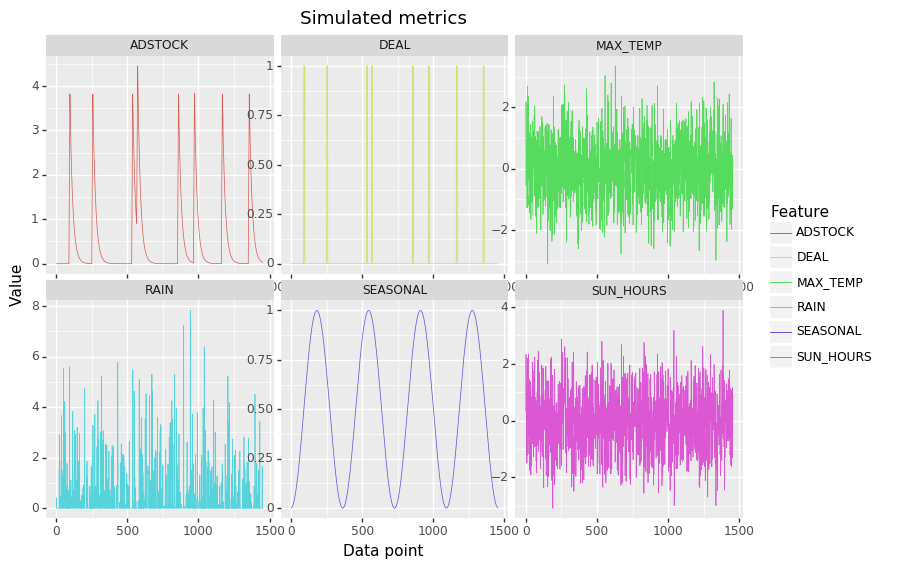

<ggplot: (-9223371928883766058)>

In [7]:
# Plot metrics
(ggplot(metrics.drop(["WEEK","YEAR","DOY"], axis=1).reset_index().melt(
    id_vars=["index"]),
       aes(x="index", y="value", colour="variable")) +
 geom_line(size=0.3) +
 facet_wrap("~variable", scales="free") +
 theme(figure_size=(9,6)) +
 labs(title="Simulated metrics",
      x="Data point",
      y="Value",
      color="Feature")
)

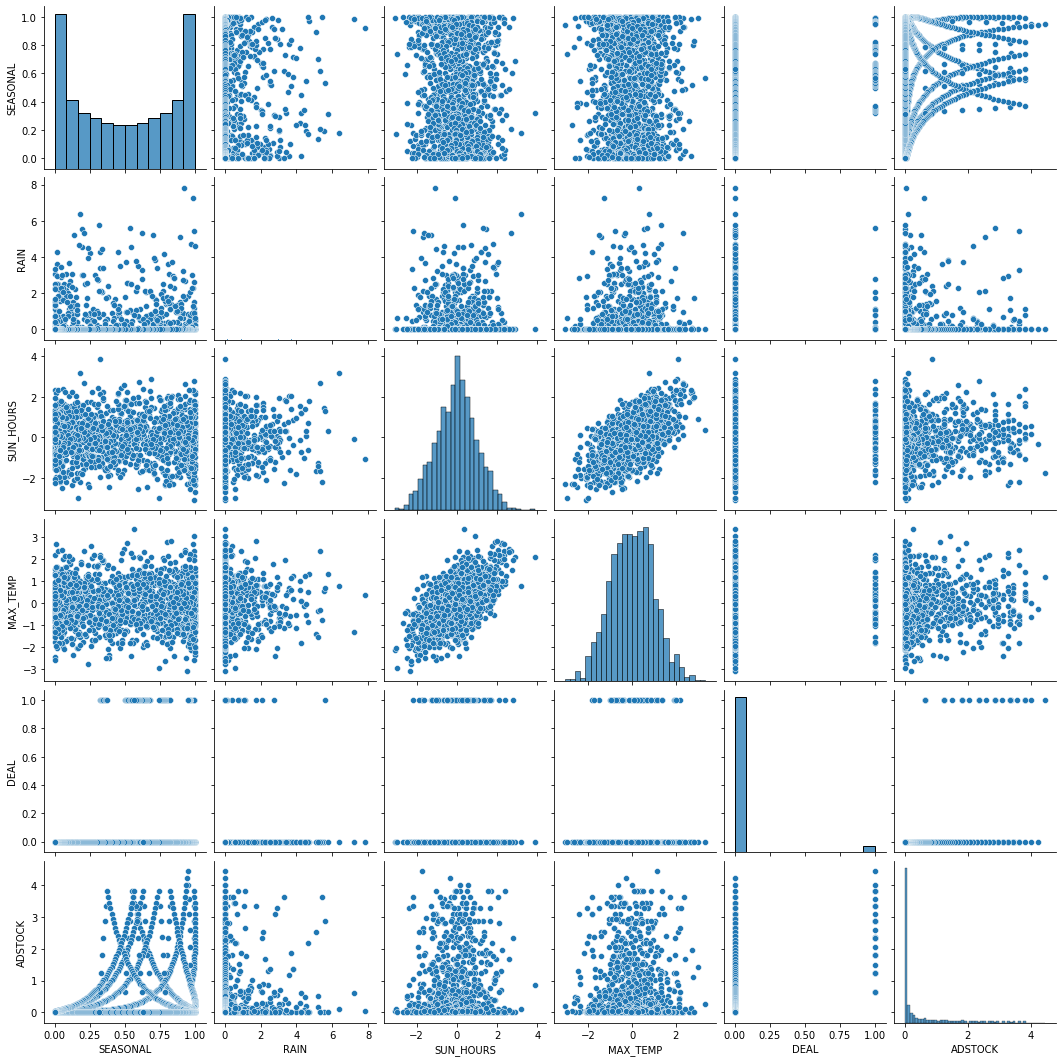

In [8]:
# Correlation plots
pairplot(metrics.drop(["WEEK","YEAR","DOY"], axis=1))

In [9]:
def build_data(metrics, coefs, use_noise=True, seed=None):
    """Build 'actual' values for simulated sales from standardised metrics
    
    Parameters
    ----------
    metrics : pandas DataFrame
        data frame containing metrics generated by build_metrics
        
    coefs : dict(metric: value)
        lookup dictionary of metric to coefficient
        
    use_noise : bool, optional default=True
        whether or not to generate random noise around the base
        
    seed : int, optional default=None
        Random seed for numpy randomstate
        
    Returns
    -------
    metric_contribs : pandas DataFrame
        Simulated effects of metrics
    """
    if seed:
        np.random.seed(seed)
    
    # Number of data points in metrics
    num_rows = metrics.shape[0]
    
    # Get random normal noise if required
    if use_noise == True:
        noise_factor = np.random.normal(1, coefs["NOISE"], num_rows)
    else:
        noise_factor = 1

    # Build data
    metric_contribs = pd.DataFrame(
        (coefs["INTERCEPT"] + metrics["SEASONAL"] * coefs["SEASONAL"]),
        columns=["SEASONAL"])
    
    metric_contribs = metric_contribs.assign(
        NOISE = noise_factor * metric_contribs["SEASONAL"] - metric_contribs["SEASONAL"]
    )
    
    base = metric_contribs["SEASONAL"]
    
    # Main effects    
    metric_contribs = metric_contribs.assign(
        RAIN = metrics["RAIN"] * coefs["RAIN"] * base / 2,
        MAX_TEMP = metrics["MAX_TEMP"] * coefs["MAX_TEMP"] * base,
        MAX_TEMP_LAG1 = coefs["MAX_TEMP_LAG1"] * metrics["MAX_TEMP"].shift(1, fill_value=0) * base,
        SUN_HOURS = metrics["SUN_HOURS"] * coefs["SUN_HOURS"] * base,
#         DEAL = coefs["DEAL"] * metrics["DEAL"] * base * (np.random.normal(
#             1, 0.25, size=num_rows)),
        ADSTOCK = coefs["ADSTOCK"] * metrics["ADSTOCK"] * base * (np.random.normal(1, 0.25, size=num_rows))
    )

    # Interactions
    metric_contribs = metric_contribs.assign(
        MAX_TEMP_DEAL = metrics["MAX_TEMP"] * metrics["ADSTOCK"] * coefs["MAX_TEMP_ADSTOCK"] * base,
        RAIN_DEAL = metrics["RAIN"] * metrics["ADSTOCK"] * coefs["RAIN_ADSTOCK"] * base)
    
    metric_contribs["Y"] = [max(x, 0) for x in metric_contribs.sum(axis=1)]
    
    return metric_contribs

In [10]:
# Build simulated effects of the metrics
coefs = {
    "INTERCEPT":200,
    "SEASONAL": 100,
    #"DEAL": 0.6,
    "ADSTOCK": 0.1,
    "RAIN": -0.08,
    "MAX_TEMP": 0.1,
    "MAX_TEMP_LAG1": 0.05,
    "SUN_HOURS": 0.05,
    "MAX_TEMP_ADSTOCK": 0.01,
    "RAIN_ADSTOCK": 0.01,
    "NOISE": 0.005
}

sales = build_data(metrics, coefs, use_noise=True, seed=42)
sales

SEASONAL     NOISE      RAIN   MAX_TEMP  MAX_TEMP_LAG1  SUN_HOURS  \
0     200.000000  0.496714 -0.000000 -10.839827       0.000000   3.294282   
1     200.007449 -0.138269 -0.000000  -7.208218      -5.420115   5.164290   
2     200.029793  0.647785 -3.256811  43.621293      -3.604512  23.288277   
3     200.067026  1.523540 -0.000000  16.400666      21.814706   9.337154   
4     200.119136 -0.234293 -0.000000  14.225916       8.202469   0.244561   
...          ...       ...       ...        ...            ...        ...   
1451  200.186109  1.703799 -0.000000   8.765690      -6.452247  11.634450   
1452  200.119136  0.240897 -0.000000   8.775735       4.381379  -2.449917   
1453  200.067026  2.602555 -0.000000 -26.091058       4.386725 -11.100330   
1454  200.029793  0.565594 -0.000000  -0.937897     -13.043101  -0.853973   
1455  200.007449 -1.760828 -0.000000   5.912160      -0.468896   8.829811   

       ADSTOCK  MAX_TEMP_DEAL  RAIN_DEAL           Y  
0     0.000000      -0.000000        0.0  192.951169  
1     0.000000      -0.000000        0.0  192.405135  
2     0.000000       0.000000        0.0  260.725825  
3     0.000000       0.000000        0.0  249.143093  
4     0.000000       0.000000        0.0  222.557790  
...        ...            ...        ...         ...  
1451  0.445253       0.027174        0.0  216.310228  
1452  0.515055       0.025450        0.0  211.607734  
1453  0.736248      -0.073055        0.0  170.528111  
1454  0.450474      -0.002439        0.0  186.208450  
1455  0.544827       0.014780        0.0  213.079303  

[1456 rows x 10 columns]

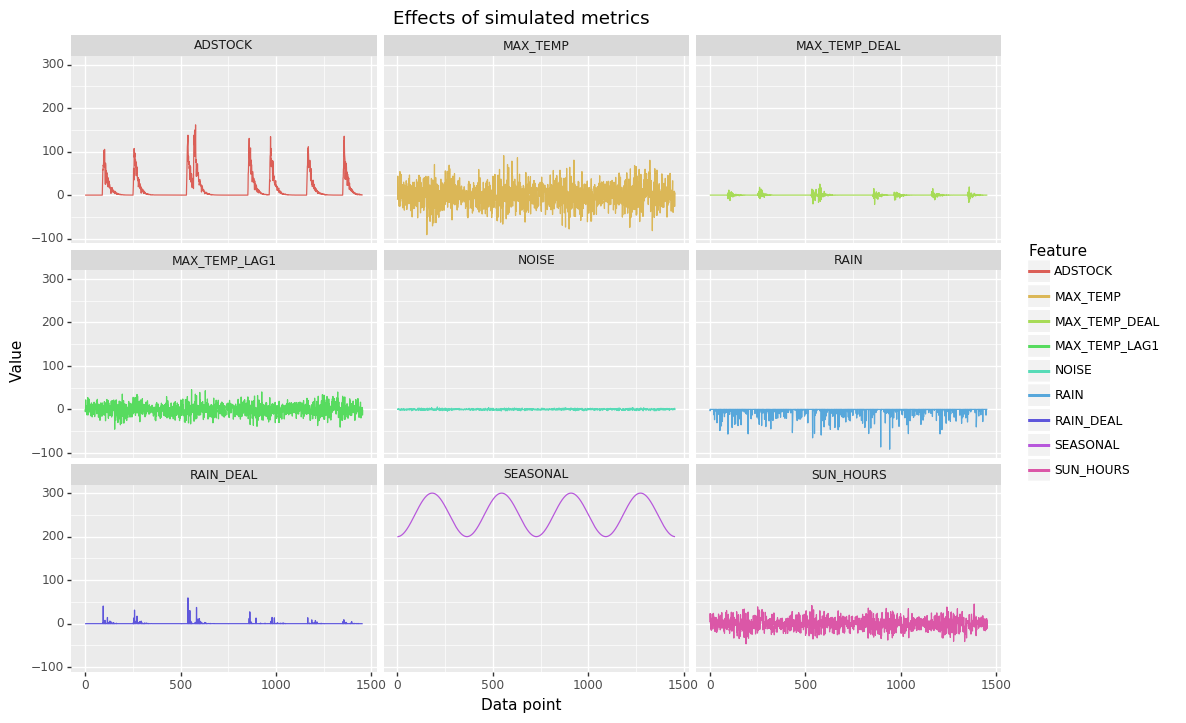

<ggplot: (-9223371928868978004)>

In [11]:
# Plot simulated effects of the metrics
(ggplot(sales.drop("Y", axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", color="variable")) +
 geom_line() +
 facet_wrap("~variable", ncol=3) +
 theme(figure_size=(12,8)) +
 labs(title="Effects of simulated metrics",
      x="Data point",
      y="Value",
      color="Feature")
)

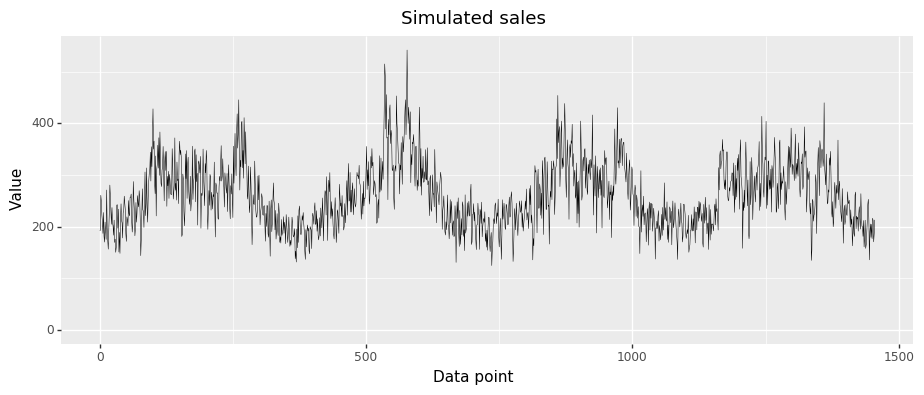

<ggplot: (-9223371928881044564)>

In [12]:
# Plot final simulated sales
(ggplot(sales.reset_index(),
        aes(x = "index", y = "Y")) +
 geom_line(size=0.2) +
 theme(figure_size=(11,4)) +
 coord_cartesian(ylim=(0,None)) +
 labs(title="Simulated sales",
      x="Data point",
      y="Value")
)

## Case 1: Simple dataset

Compare exact Shapley values with an 'adjusted' version for a model of seasonal demand and deals.

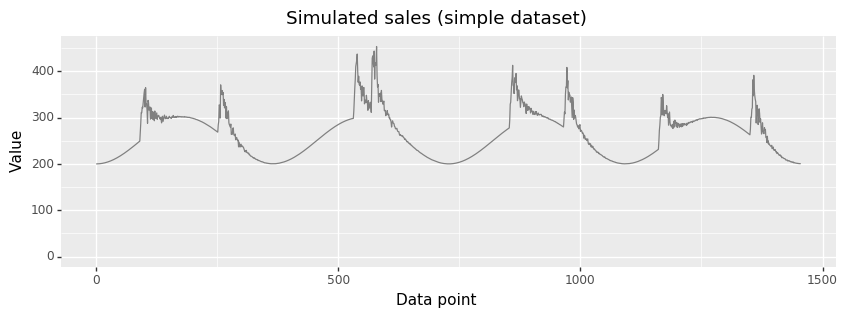

<ggplot: (-9223371928868234485)>

In [13]:
X_1 = metrics[["DOY", "DEAL"]]
X_1["Y"] = sales[["SEASONAL", "ADSTOCK"]].sum(axis=1)

(ggplot(X_1.reset_index(),
        aes(x = "index", y = "Y")) +
 geom_line(color="grey") +
 theme(figure_size=(10,3)) +
 labs(x="Data point", y="Value", title="Simulated sales (simple dataset)") +
 coord_cartesian(ylim=(0,None))
)

In [14]:
# Train/test split (save most recent year for test data)
split_point_1 = X_1.shape[0] - 364

X_train_1 = X_1.loc[:(split_point_1 - 1)].drop("Y", axis=1)
y_train_1 = X_1.loc[:(split_point_1 - 1), "Y"]

X_test_1 = X_1.loc[split_point_1:].drop("Y", axis=1)
y_test_1 = X_1.loc[split_point_1:, "Y"]

print(f"Train: {len(X_train_1)}, Test: {len(X_test_1)}")

Train: 1092, Test: 364


### Estimate Adstock parameters

In [15]:
# Optimisation function
def opt_hp (preprocessor, regressor, space, X_train, y_train, fit_params=None,
            cv_splitter=KFold, cv_col=None, n_folds=5, max_evals=50,
            plot_history=True):
    
    # Loss function
    def objective_hp(params):

        #print(params)
        
        # Set adstock params
        preprocessor.set_params(adstocktransformer__decay=params["decay"])
        if "saturation" in params:
            preprocessor.set_params(adstocktransformer__saturation=params["saturation"])
        if "round_digits" in params:
            preprocessor.set_params(adstocktransformer__round_digits=params["round_digits"])
        
        # Fit adstock across total training data
        X_train_prep = preprocessor.fit_transform(X_train)
        
        # Initialise regressor
        regressor.set_params(**params)

        return -np.mean(cross_val_score(regressor, X_train_prep, y_train,
                                        fit_params=fit_params,
                                        cv=cv_splitter,
                                        groups=cv_col,
                                        n_jobs=-1,
                                        scoring='neg_mean_squared_error'))
    
    # Run optimisation
    time_start_hp = dt.datetime.now()
    trials_hp = Trials()
    best_hp = fmin(objective_hp, space, algo=tpe.suggest,
                   max_evals=max_evals, trials=trials_hp)
    time_elapsed_hp = dt.datetime.now() - time_start_hp
    
    # Get iteration history
    history_hp = pd.DataFrame([[int(x["tid"]), x["result"]["loss"]] + 
                  [x["misc"]["vals"][y][0] for y in space.keys()]
                  for x in trials_hp.trials],
                 columns=["iteration", "loss"] + list(space.keys())).assign(
        best_value = lambda x: x.loss.cummin())

    # Add flag if iteration was the best value
    history_hp = history_hp.assign(
        best_iteration = lambda x: x["loss"] == min(trials_hp.losses()))
    
    if plot_history==True:
        g = (ggplot(history_hp, aes(x="iteration", y="loss")) +
             geom_point(colour="blue", alpha=0.4) +
             geom_line(aes(x="iteration", y="best_value"), colour="red") +
             geom_smooth(colour="grey", linetype="dashed", size=0.4, se=False) +
             labs(title="Optimisation history",
                  x="Iteration",
                  y="Objective value"
                 ) +
             theme(figure_size=(8,4))
            )
    else:
        g = None
    
    best_hp = space_eval(space, best_hp)
    
    return best_hp, history_hp, time_elapsed_hp, g

In [16]:
prep_hp_1 = make_column_transformer(
    (AdstockTransformer(), ["DEAL"]),
    remainder="passthrough"
)

params_hp_1 = {
    "boosting_type": "gbrt",
    "n_jobs": 4,
    "monotone_constraints": [1, 0]
}

reg_hp_1 = lgb.LGBMRegressor(**params_hp_1)

space_hp_1 = {"num_leaves": scope.int(hp.quniform("num_leaves", 24, 64, 1)),
            "n_estimators": scope.int(hp.quniform("n_estimators", 256, 2500, 1)),
            "decay": hp.uniform("decay", 0.5, 1.0)
            #,"saturation": hp.uniform("saturation", 0.7, 1)
            }

best_hp_1, history_hp_1, time_elapsed_hp_1, g_hp_1 = opt_hp(
    prep_hp_1,
    reg_hp_1,
    space_hp_1,
    X_train_1,
    y_train_1,
    #fit_params=fit_params_hp_1,
    cv_splitter=TimeSeriesSplit(n_splits=5),
    max_evals=50
)

print()
print("Time elapsed: {}".format(time_elapsed_hp_1))
print("Min objective: {:.4f}".format(min(history_hp_1.loss)))
print()
best_hp_1

100%|█████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.14s/trial, best loss: 795.6304829844124]

Time elapsed: 0:01:47.234357
Min objective: 795.6305



{'decay': 0.9127982937240324, 'n_estimators': 1090, 'num_leaves': 35}

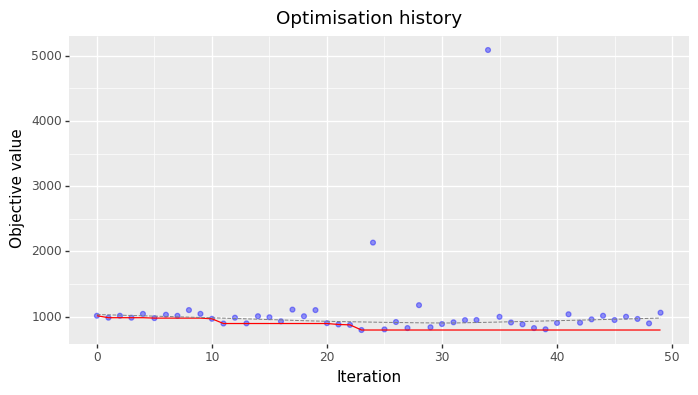

<ggplot: (107988410870)>

In [17]:
# Show history plot
g_hp_1

In [18]:
# Parallel coordinates plot
fig = px.parallel_coordinates(
    history_hp_1,
    color="loss",
    dimensions=list(space_hp_1.keys()) + ["loss"])
fig.show()

### Fit model

In [19]:
params_1_adstock = {k:v for k,v in space_eval(space_hp_1, best_hp_1).items() if k in ["decay", "saturation"]}
params_1 = {k:v for k,v in space_eval(space_hp_1, best_hp_1).items() if k not in ["decay", "saturation"]}
params_1.update({
    "n_jobs": 4,
    "boosting_type": "gbrt",
    "monotone_constraints": [1, 0]
})
params_1

{'n_estimators': 1090,
 'num_leaves': 35,
 'n_jobs': 4,
 'boosting_type': 'gbrt',
 'monotone_constraints': [1, 0]}

Fit optimised adstock parameter to whole dataset (and then separate into train/test).  
This is because the adstock feature might start in the training data and end in the test data.

In [20]:
prep_1 = make_column_transformer(
    (AdstockTransformer(**params_1_adstock), ["DEAL"]),
    remainder="passthrough"
)

X_1_prep = pd.DataFrame(prep_1.fit_transform(X_1.drop("Y", axis=1)),
                        columns=["DEAL", "DOY"])
X_train_1_prep = X_1_prep.loc[:split_point_1 - 1]
X_test_1_prep = X_1_prep.loc[split_point_1:]

print(f"Train: {len(X_train_1_prep)}, Test: {len(X_test_1_prep)}")

Train: 1092, Test: 364


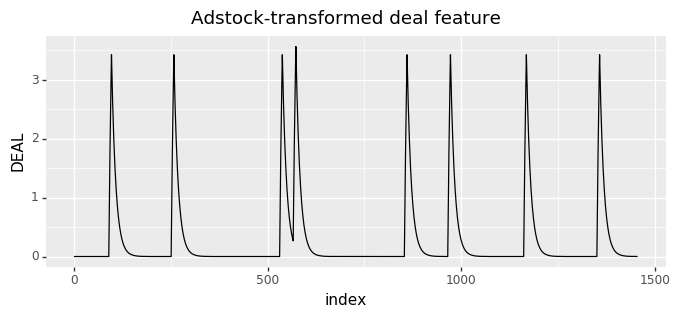

<ggplot: (-9223371928866366064)>

In [21]:
(ggplot(X_1_prep.reset_index(), aes(x="index", y="DEAL")) +
 geom_line() +
 theme(figure_size=(8,3)) +
 labs(title="Adstock-transformed deal feature")
)

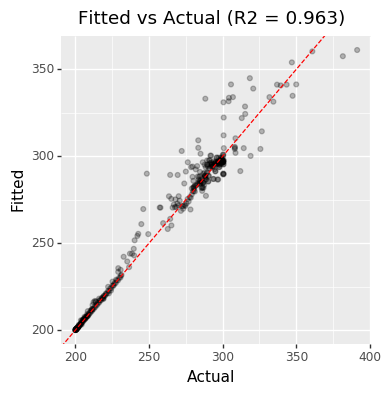

<ggplot: (-9223371928863781397)>

In [22]:
lgb_model_1 = lgb.LGBMRegressor(**params_1)
lgb_model_1.fit(X_train_1_prep, y_train_1)

# Get diagnostics
diagnostics_1 = RegressionDiagnostics(lgb_model_1)
diagnostics_1.fit(X_test_1_prep, y_test_1)

diagnostics_1.fitted_actual(sample_frac=1.0)

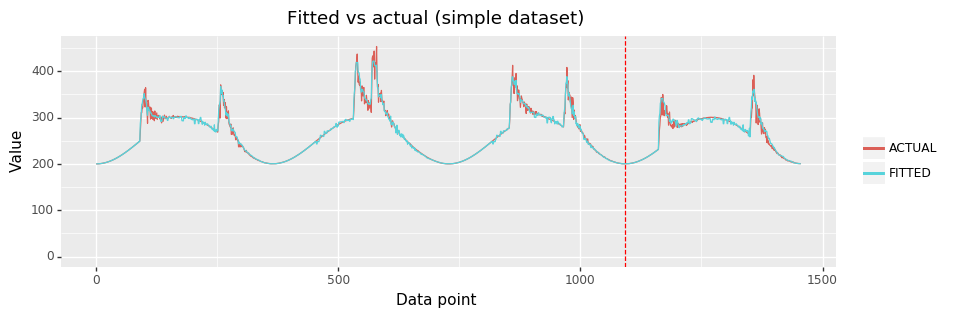

<ggplot: (-9223371928863736618)>

In [23]:
# Get predicted values for all data points
yhat_all_1a = metrics[["YEAR", "DOY"]].assign(
    ACTUAL = X_1.Y,
    FITTED = lgb_model_1.predict(X_1_prep)
)

# Train and test labels for plot
train_test_label_1a = pd.DataFrame(
    {"x": [split_point_1 * 0.5,
           split_point_1 + (metrics.shape[0] - split_point_1) * 0.5],
     "y": [0, 0],
     "label": ["TRAIN", "TEST"]})

# Plot actual vs predicted
(ggplot(yhat_all_1a.drop(["YEAR", "DOY"], axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", colour="variable")) +
 geom_line() +
 geom_vline(aes(xintercept=split_point_1), colour="red",
           linetype="dashed") +
#  geom_text(train_test_label_1a,
#            aes(x="x", y="y", label="label"),
#           inherit_aes=False, colour="red") +
 theme(figure_size=(10,3)) +
 coord_cartesian(ylim=(0,None)) +
 labs(x="Data point", y="Value",
      title="Fitted vs actual (simple dataset)",
      color="")
)

### Shapley values (DOY always first)

In [24]:
# Calculate Shapley values
shapley_est_1c = shapley.ShapleyEstimator(model=lgb_model_1,
                                          max_iter=1,
                                          base_features=["DOY"],
                                          tol=-np.inf)
shapley_est_1c.fit(X_test_1_prep)

Start time: 14:16:10.795680
Iteration:      1, Difference: 1.000000, Time: 14:16:12.319007, Coalitions seen: 100.00%
Finished
Iteration:      1, Difference: 1.000000, Time: 14:16:12.320008, Coalitions seen: 100.00%


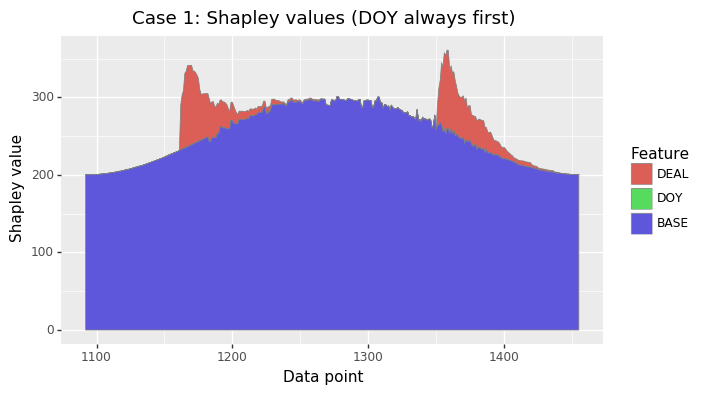

<ggplot: (107993060079)>

In [25]:
# Plot Shapley values
shapley_est_1c_melt = shapley_est_1c.get_shapley_values().assign(DOY = 0).reset_index().melt(
    id_vars="index")
shapley_est_1c_melt = shapley_est_1c_melt.assign(
    variable = pd.Categorical(shapley_est_1c_melt["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_est_1c_melt,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (7, 4)) +
 labs(title="Case 1: Shapley values (DOY always first)",
      x="Data point",
      y="Shapley value",
      fill="Feature"
     )
)

## Case 2: Full Dataset

In [26]:
# Build dataset, this time including weather metrics
X_2 = metrics[["DOY", "RAIN", "SUN_HOURS", "MAX_TEMP", "DEAL"]].assign(
    MAX_TEMP_LAG1 = metrics["MAX_TEMP"].shift(1, fill_value=0),
    Y = sales.Y)
X_2.head()

DOY      RAIN  SUN_HOURS  MAX_TEMP  DEAL  MAX_TEMP_LAG1           Y
0    0  0.000000   0.329428 -0.541991   0.0       0.000000  192.951169
1    1  0.000000   0.516410 -0.360398   0.0      -0.541991  192.405135
2    2  0.407041   2.328481  2.180740   0.0      -0.360398  260.725825
3    3  0.000000   0.933403  0.819759   0.0       2.180740  249.143093
4    4  0.000000   0.024442  0.710872   0.0       0.819759  222.557790

In [27]:
# Train/test split
split_point_2 = sales.shape[0]-364

X_train_2 = X_2.loc[:(split_point_2 - 1)].drop("Y", axis=1)
y_train_2 = X_2.loc[:(split_point_2 - 1), "Y"]

X_test_2 = X_2.loc[split_point_2:].drop("Y", axis=1)
y_test_2 = X_2.loc[split_point_2:, "Y"]

print(f"Train: {len(X_train_2)}, Test: {len(X_test_2)}")

Train: 1092, Test: 364


### Estimate Adstock parameters

In [28]:
prep_hp_2 = make_column_transformer(
    (AdstockTransformer(), ["DEAL"]),
    remainder="passthrough"
)

params_hp_2 = {
    "boosting_type": "gbrt",
    "n_jobs": 4,
    "monotone_constraints": [1, 0, -1, 1, 1, 1]
}

reg_hp_2 = lgb.LGBMRegressor(**params_hp_2)

space_hp_2 = {"num_leaves": scope.int(hp.quniform("num_leaves", 24, 64, 1)),
            "n_estimators": scope.int(hp.quniform("n_estimators", 256, 2500, 1)),
            "decay": hp.uniform("decay", 0.5, 1.0)
            #,"saturation": hp.uniform("saturation", 0.9, 1)
            }

best_hp_2, history_hp_2, time_elapsed_hp_2, g_hp_2 = opt_hp(
    prep_hp_2,
    reg_hp_2,
    space_hp_2,
    X_train_2,
    y_train_2,
    #fit_params=fit_params_hp_2,
    cv_splitter=TimeSeriesSplit(n_splits=5),
    max_evals=50
)

print()
print("Time elapsed: {}".format(time_elapsed_hp_2))
print("Min objective: {:.4f}".format(min(history_hp_2.loss)))
print()
best_hp_2

100%|█████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.79s/trial, best loss: 880.5479327723755]

Time elapsed: 0:02:19.300458
Min objective: 880.5479



{'decay': 0.9206691925749695, 'n_estimators': 2066, 'num_leaves': 38}

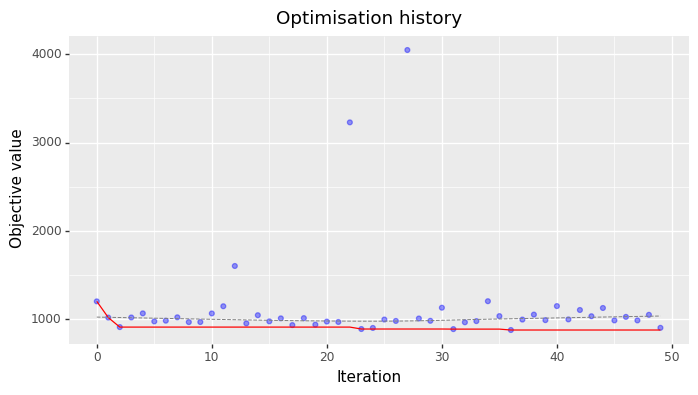

<ggplot: (-9223371928861646392)>

In [29]:
# Show history plot
g_hp_2

In [30]:
# Parallel coordinates plot
fig = px.parallel_coordinates(
    history_hp_2,
    color="loss",
    dimensions=list(space_hp_2.keys()) + ["loss"])
fig.show()

### Fit model

In [31]:
params_2_adstock = {k:v for k,v in space_eval(space_hp_2, best_hp_2).items() if k in ["decay", "saturation"]}
params_2 = {k:v for k,v in space_eval(space_hp_2, best_hp_2).items() if k not in ["decay", "saturation"]}
params_2.update({
    "n_jobs": 4,
    "boosting_type": "gbrt",
    "monotone_constraints": [1, 0, -1, 1, 1, 1]
})
params_2

{'n_estimators': 2066,
 'num_leaves': 38,
 'n_jobs': 4,
 'boosting_type': 'gbrt',
 'monotone_constraints': [1, 0, -1, 1, 1, 1]}

In [32]:
prep_2 = make_column_transformer(
    (AdstockTransformer(**params_2_adstock), ["DEAL"]),
    remainder="passthrough"
)

X_2_prep = pd.DataFrame(prep_2.fit_transform(X_2.drop("Y", axis=1)),
                        columns=["DEAL"] + [x for x in X_train_2.columns if x != "DEAL"])
X_train_2_prep = X_2_prep.loc[:split_point_1 - 1]
X_test_2_prep = X_2_prep.loc[split_point_1:]

print(f"Train: {len(X_train_2_prep)}, Test: {len(X_test_2_prep)}")

Train: 1092, Test: 364


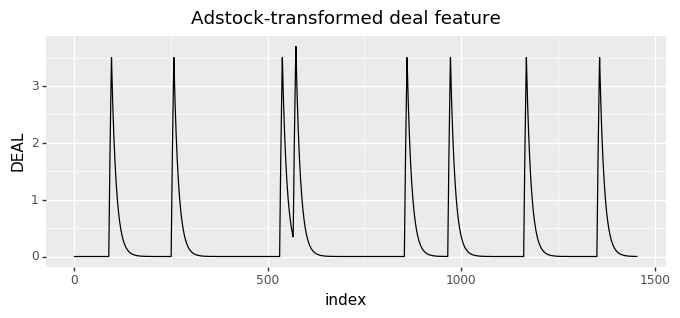

<ggplot: (-9223371928861638894)>

In [33]:
(ggplot(X_2_prep.reset_index(), aes(x="index", y="DEAL")) +
 geom_line() +
 theme(figure_size=(8,3)) +
 labs(title="Adstock-transformed deal feature")
)

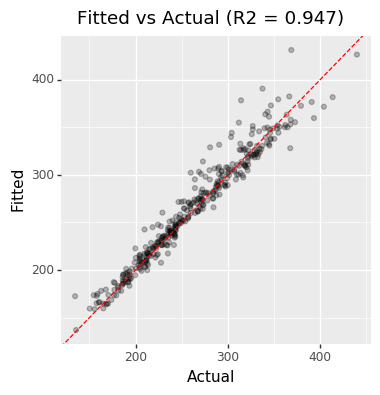

<ggplot: (-9223371928861112632)>

In [34]:
lgb_model_2 = lgb.LGBMRegressor(**params_2)
lgb_model_2.fit(X_train_2_prep, y_train_2)

# Get diagnostics
diagnostics_2 = RegressionDiagnostics(lgb_model_2)
diagnostics_2.fit(X_test_2_prep, y_test_2)

diagnostics_2.fitted_actual(sample_frac=1.0)

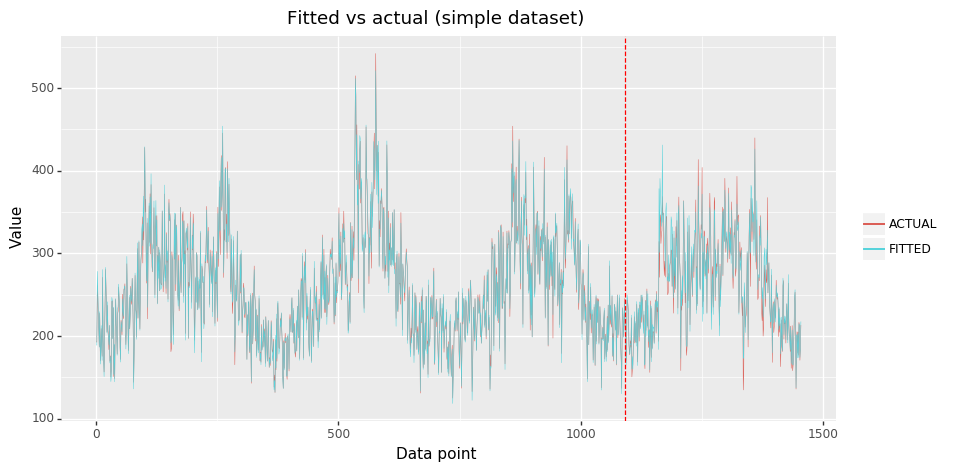

<ggplot: (-9223371928861108988)>

In [35]:
# Get predicted values for all data points
yhat_all_2a = metrics[["YEAR", "DOY"]].assign(
    ACTUAL = X_2.Y,
    FITTED = lgb_model_2.predict(X_2_prep)
)

# Train and test labels for plot
train_test_label_2a = pd.DataFrame(
    {"x": [split_point_2 * 0.5,
           split_point_2 + (metrics.shape[0] - split_point_2) * 0.5],
     "y": [0, 0],
     "label": ["TRAIN", "TEST"]})

# Plot actual vs predicted
(ggplot(yhat_all_2a.drop(["YEAR", "DOY"], axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", colour="variable")) +
 geom_line(size=0.2) +
 geom_vline(aes(xintercept=split_point_2), colour="red",
           linetype="dashed") +
#  geom_text(train_test_label_1a,
#            aes(x="x", y="y", label="label"),
#           inherit_aes=False, colour="red") +
 theme(figure_size=(10,5)) +
 labs(x="Data point", y="Value",
      title="Fitted vs actual (simple dataset)",
      color="")
)

### Shapley values (DOY always first)

In [36]:
# Calculate Shapley values
shapley_est_2c = shapley.ShapleyEstimator(model=lgb_model_2,
                                         max_iter=np.math.factorial(5),
                                         base_features=["DOY"],
                                         tol=-np.inf)
shapley_est_2c.fit(X_test_2_prep)

Start time: 14:18:35.556975
Iteration:      1, Difference: 1.000000, Time: 14:18:35.716975, Coalitions seen: 16.13%
Iteration:      2, Difference: 0.023755, Time: 14:18:35.875975, Coalitions seen: 19.35%
Iteration:      3, Difference: 0.023899, Time: 14:18:35.896978, Coalitions seen: 22.58%
Iteration:      4, Difference: 0.019294, Time: 14:18:35.926975, Coalitions seen: 25.81%
Iteration:      5, Difference: 0.017325, Time: 14:18:35.955976, Coalitions seen: 29.03%
Iteration:      6, Difference: 0.012048, Time: 14:18:35.957976, Coalitions seen: 29.03%
Iteration:      7, Difference: 0.010756, Time: 14:18:35.982975, Coalitions seen: 32.26%
Iteration:      8, Difference: 0.008969, Time: 14:18:35.984976, Coalitions seen: 32.26%
Iteration:      9, Difference: 0.008375, Time: 14:18:36.012975, Coalitions seen: 35.48%
Iteration:     10, Difference: 0.009084, Time: 14:18:36.032981, Coalitions seen: 38.71%
Iteration:     20, Difference: 0.004874, Time: 14:18:36.153975, Coalitions seen: 51.61%
Iter

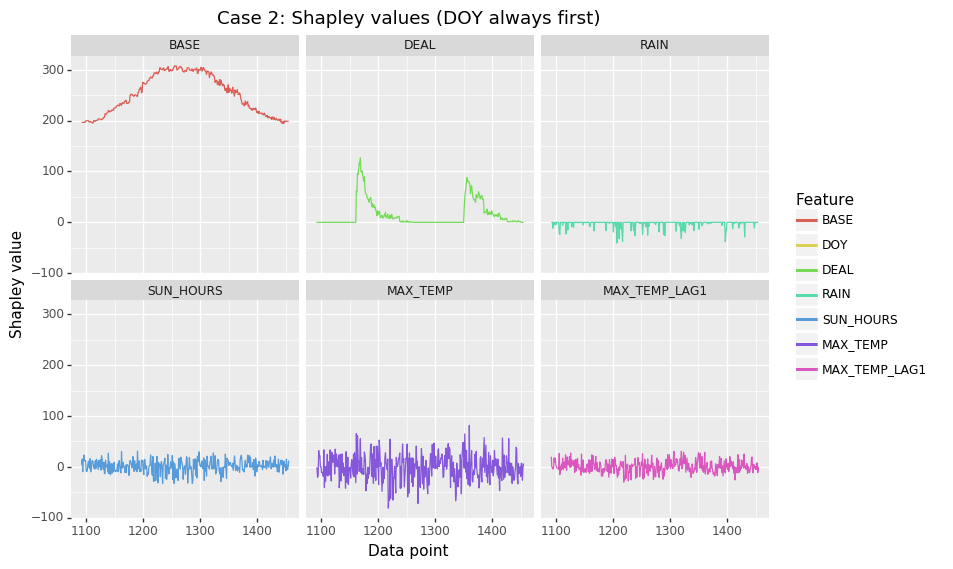

<ggplot: (-9223371928859832860)>

In [37]:
# Plot Shapley values, facetted by feature
shapley_est_2c_melt = shapley_est_2c.get_shapley_values().reset_index().melt(
    id_vars="index")
shapley_est_2c_melt = shapley_est_2c_melt.assign(
    variable = pd.Categorical(shapley_est_2c_melt["variable"],
                              categories=["BASE", "DOY", "DEAL",
                                          "RAIN", "SUN_HOURS", "MAX_TEMP",
                                          "MAX_TEMP_LAG1"],
                              ordered=False))

(ggplot(shapley_est_2c_melt,
        aes(x="index", y="value", colour="variable")) + 
 geom_line() +
 theme(figure_size = (9, 6)) +
 labs(title="Case 2: Shapley values (DOY always first)",
     x="Data point",
     y="Shapley value",
     color="Feature") +
 facet_wrap("~variable", ncol=3)
)